In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [2]:
dfi = pd.read_csv('./Data/Stock/^N100.csv',parse_dates=True,index_col='Datetime')
dfi

,Close,High,Low,Open
Datetime,,,,
2022-10-31 08:00:00+00:00,1190.329956,1195.300049,1188.359985,1192.170044
2022-10-31 09:00:00+00:00,1191.829956,1193.239990,1189.839966,1190.439941
2022-10-31 10:00:00+00:00,1192.339966,1192.750000,1191.119995,1191.949951
2022-10-31 11:00:00+00:00,1191.219971,1193.630005,1190.520020,1192.359985
2022-10-31 12:00:00+00:00,1191.569946,1191.890015,1190.219971,1191.189941
...,...,...,...,...
2024-10-28 12:00:00+00:00,1476.699951,1477.020020,1471.530029,1473.359985
2024-10-28 13:00:00+00:00,1476.359985,1477.949951,1475.449951,1476.719971
2024-10-28 14:00:00+00:00,1480.760010,1481.479980,1474.949951,1476.380005


In [3]:
# dfi['date'] = pd.to_datetime(dfi['Time'])
# df = dfi.loc[dfi['date'] > '2024-07-19']
# df

In [4]:
df = dfi[['Open','High','Low','Close']]
df = df.dropna()
df

,Open,High,Low,Close
Datetime,,,,
2022-10-31 08:00:00+00:00,1192.170044,1195.300049,1188.359985,1190.329956
2022-10-31 09:00:00+00:00,1190.439941,1193.239990,1189.839966,1191.829956
2022-10-31 10:00:00+00:00,1191.949951,1192.750000,1191.119995,1192.339966
2022-10-31 11:00:00+00:00,1192.359985,1193.630005,1190.520020,1191.219971
2022-10-31 12:00:00+00:00,1191.189941,1191.890015,1190.219971,1191.569946
...,...,...,...,...
2024-10-28 12:00:00+00:00,1473.359985,1477.020020,1471.530029,1476.699951
2024-10-28 13:00:00+00:00,1476.719971,1477.949951,1475.449951,1476.359985
2024-10-28 14:00:00+00:00,1476.380005,1481.479980,1474.949951,1480.760010


In [5]:
df['nxt_target'] = df['Close'].shift(-1)
df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]

/tmp/ipykernel_3031/2437957435.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]
/tmp/ipykernel_3031/2437957435.py:2: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4599 entries, 2022-10-31 08:00:00+00:00 to 2024-10-28 16:00:00+00:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        4599 non-null   float64
 1   High        4599 non-null   float64
 2   Low         4599 non-null   float64
 3   Close       4599 non-null   float64
 4   nxt_target  4599 non-null   float64
dtypes: float64(5)
memory usage: 215.6 KB


In [7]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,Open,High,Low,Close,nxt_target
Datetime,,,,,
2022-10-31 08:00:00+00:00,1192.170044,1195.300049,1188.359985,1190.329956,1191.829956
2022-10-31 09:00:00+00:00,1190.439941,1193.239990,1189.839966,1191.829956,1192.339966
2022-10-31 10:00:00+00:00,1191.949951,1192.750000,1191.119995,1192.339966,1191.219971
2022-10-31 11:00:00+00:00,1192.359985,1193.630005,1190.520020,1191.219971,1191.569946
2022-10-31 12:00:00+00:00,1191.189941,1191.890015,1190.219971,1191.569946,1193.630005
...,...,...,...,...,...
2024-06-06 09:00:00+00:00,1544.359985,1545.609985,1543.839966,1545.310059,1546.920044
2024-06-06 10:00:00+00:00,1545.390015,1546.949951,1544.719971,1546.920044,1547.290039
2024-06-06 11:00:00+00:00,1546.930054,1547.949951,1546.660034,1547.290039,1544.359985


In [8]:
train.iloc[:,-1:]

,nxt_target
Datetime,
2022-10-31 08:00:00+00:00,1191.829956
2022-10-31 09:00:00+00:00,1192.339966
2022-10-31 10:00:00+00:00,1191.219971
2022-10-31 11:00:00+00:00,1191.569946
2022-10-31 12:00:00+00:00,1193.630005
...,...
2024-06-06 09:00:00+00:00,1546.920044
2024-06-06 10:00:00+00:00,1547.290039
2024-06-06 11:00:00+00:00,1544.359985


In [9]:
train.iloc[:,:4]

,Open,High,Low,Close
Datetime,,,,
2022-10-31 08:00:00+00:00,1192.170044,1195.300049,1188.359985,1190.329956
2022-10-31 09:00:00+00:00,1190.439941,1193.239990,1189.839966,1191.829956
2022-10-31 10:00:00+00:00,1191.949951,1192.750000,1191.119995,1192.339966
2022-10-31 11:00:00+00:00,1192.359985,1193.630005,1190.520020,1191.219971
2022-10-31 12:00:00+00:00,1191.189941,1191.890015,1190.219971,1191.569946
...,...,...,...,...
2024-06-06 09:00:00+00:00,1544.359985,1545.609985,1543.839966,1545.310059
2024-06-06 10:00:00+00:00,1545.390015,1546.949951,1544.719971,1546.920044
2024-06-06 11:00:00+00:00,1546.930054,1547.949951,1546.660034,1547.290039


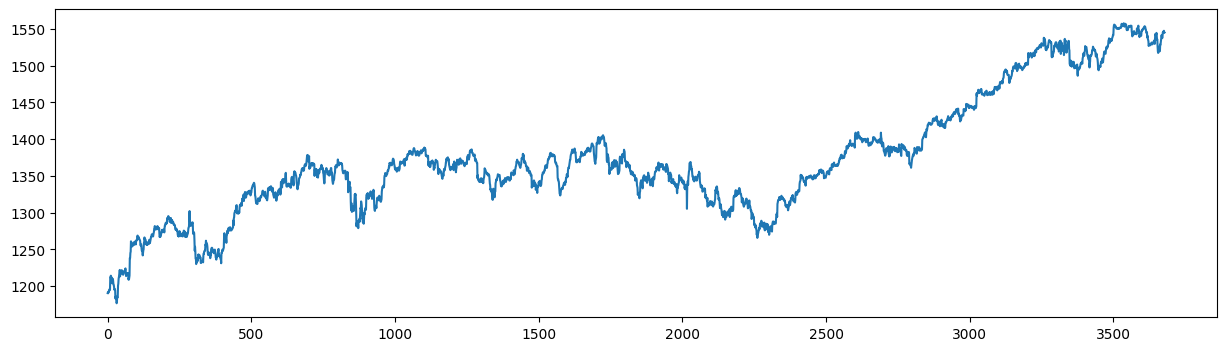

In [10]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)),train["Close"])
plt.show()

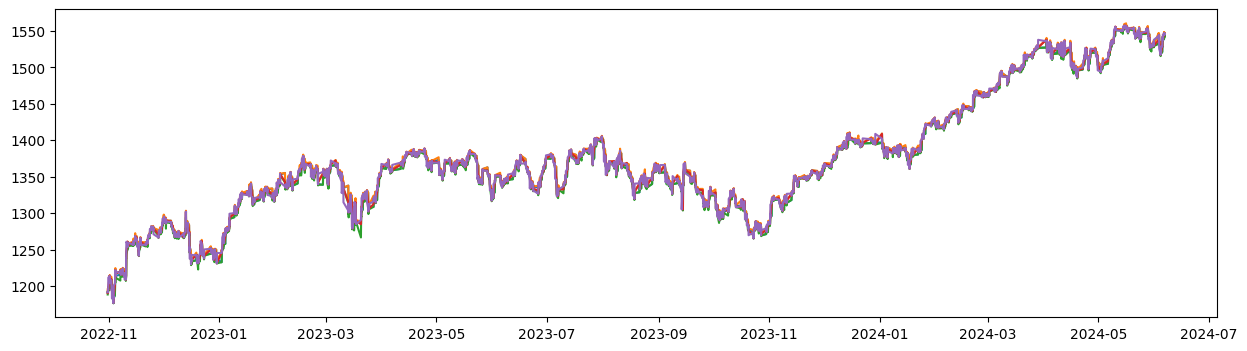

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [12]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:4])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [13]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 4
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 4
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [14]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [15]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [16]:
print(X_train.shape)
X_train[0][0]

torch.Size([3669, 10, 4])


tensor([-2.2217, -2.2125, -2.2372, -2.2455])

In [17]:
class QLSTM(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        #print(11,x.size())
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
            #batch_size, seq_length = x.size()
        else:
            seq_length, batch_size, features_size = x.size()
            #seq_length, batch_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(1,batch_size, self.hidden_size).to(x.device)  # hidden state (output)
            c_t = torch.zeros(1,batch_size, self.hidden_size).to(x.device)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            #h_t = h_t[0]
            #c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            if self.batch_first is True: x_t = x[:, t, :]
            else : x_t = x[t, : , :]
            #print(12, h_t.shape,x_t.shape, x.shape )
            

            # Concatenate input and hidden state
            v_t = torch.cat((h_t[0], x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t)
        #hidden_seq = torch.cat(hidden_seq, dim=0)
        #hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        hidden_seq = torch.cat(hidden_seq, dim = 0)
        return hidden_seq, (h_t, c_t)

class QRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [18]:
from collections import OrderedDict
class StackedQLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units,num_layers =2 , n_qubits=0, n_qlayers=1):
        super().__init__()
        label,qlstm = 'classic', QLSTM
        self.qlstms = nn.Sequential(OrderedDict([
            (f'{label} {i + 1}', qlstm(input_size= num_sensors if i == 0 else hidden_units ,hidden_size=hidden_units, batch_first=True if i == 0 else False,n_qubits = n_qubits,n_qlayers= n_qlayers)) 
                for i in range(num_layers)
        ]))
    def forward(self, inputs, parameters = None):
        outputs = None
        #print(list(enumerate(self.qlstms)))
        for i, qlstm in enumerate(self.qlstms):
            if i != 0:
                inputs = outputs
            
            outputs, parameters = qlstm(inputs, parameters)
            
        return outputs, parameters

class StackedQLSTMmodel(nn.Module):
    def __init__(self, num_sensors, hidden_units,num_layers = 2, n_qubits=0, n_qlayers=1):
        super(StackedQLSTMmodel, self).__init__()
        
        self.hidden_size = hidden_units
        self.num_layers = num_layers
                
        self.qlstm = StackedQLSTM(num_sensors, hidden_units, num_layers = num_layers,n_qubits = n_qubits,n_qlayers= n_qlayers)
        self.predict = nn.Linear(in_features=self.hidden_size, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        
        out, (hn, _) = self.qlstm(x, (h0, c0))
                
        out = self.predict(out[0]).flatten()
        #out1 = self.predict(hn).flatten()
        
        return out

In [19]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = StackedQLSTMmodel(num_sensors=4, hidden_units= 6, n_qubits=4)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

weight_shapes = (n_qlayers, n_qubits) = (1, 4)
weight_shapes = (n_qlayers, n_qubits) = (1, 4)


In [20]:
modelQ

StackedQLSTMmodel(
  (qlstm): StackedQLSTM(
    (qlstms): Sequential(
      (classic 1): QLSTM(
        (clayer_in): Linear(in_features=10, out_features=4, bias=True)
        (clayer_out): Linear(in_features=4, out_features=6, bias=True)
      )
      (classic 2): QLSTM(
        (clayer_in): Linear(in_features=12, out_features=4, bias=True)
        (clayer_out): Linear(in_features=4, out_features=6, bias=True)
      )
    )
  )
  (predict): Linear(in_features=6, out_features=1, bias=True)
)

In [21]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)
count = 0
def new_func(x):
    output = modelQ(x)
    return output

for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = new_func(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
         
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:96.48579596844502 
[2/5]  LossQ:12.446712640135956 
[3/5]  LossQ:18.392222378080987 
[4/5]  LossQ:21.68875489544007 
[5/5]  LossQ:16.397030464799172 


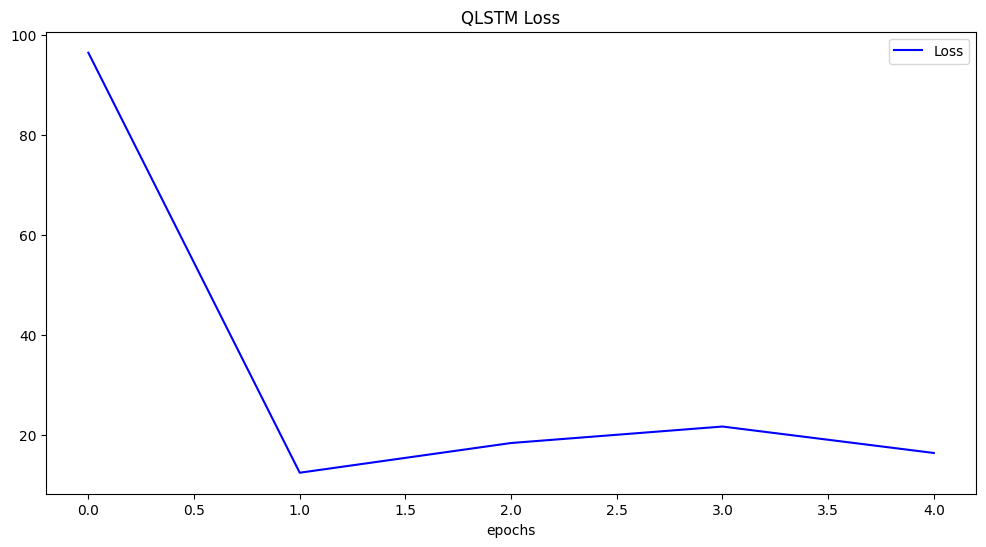

In [22]:
np.savetxt('./SavedModels/Stock/N100/loss/stacked_qlstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [23]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)


    return output

In [24]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)

print(pred_y_train)

tensor([-0.6679, -0.6374, -0.6156,  ...,  2.1423,  2.1387,  2.1318],
       grad_fn=<ViewBackward0>)


In [25]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [26]:
pred_y_train

tensor([[-0.6679],
        [-0.6374],
        [-0.6156],
        ...,
        [ 2.1423],
        [ 2.1387],
        [ 2.1318]], grad_fn=<ViewBackward0>)

In [27]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [28]:
np.savetxt('./SavedModels/Stock/N100/train/stacked_qlstm.txt',y_train_pred)
np.savetxt('./SavedModels/Stock/N100/test/stacked_qlstm.txt',y_test_pred)

Training dataset RMSE:59.48674566875784


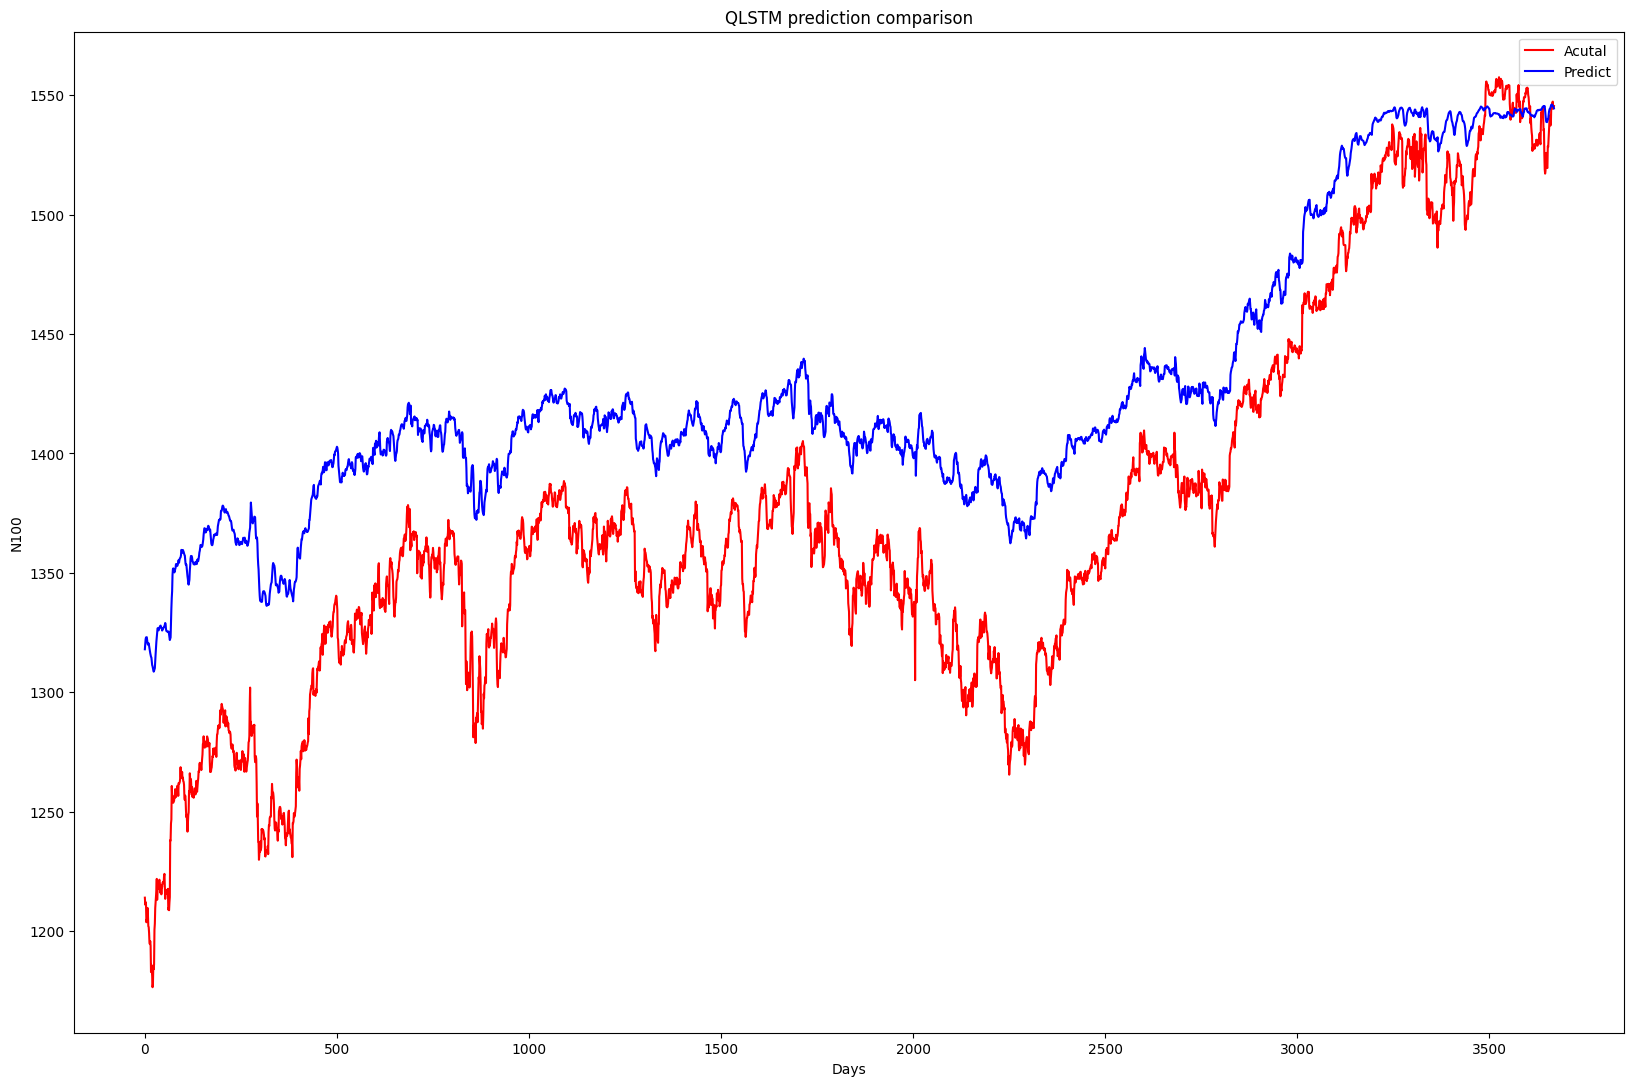

In [29]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('N100')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:21.20045832480989


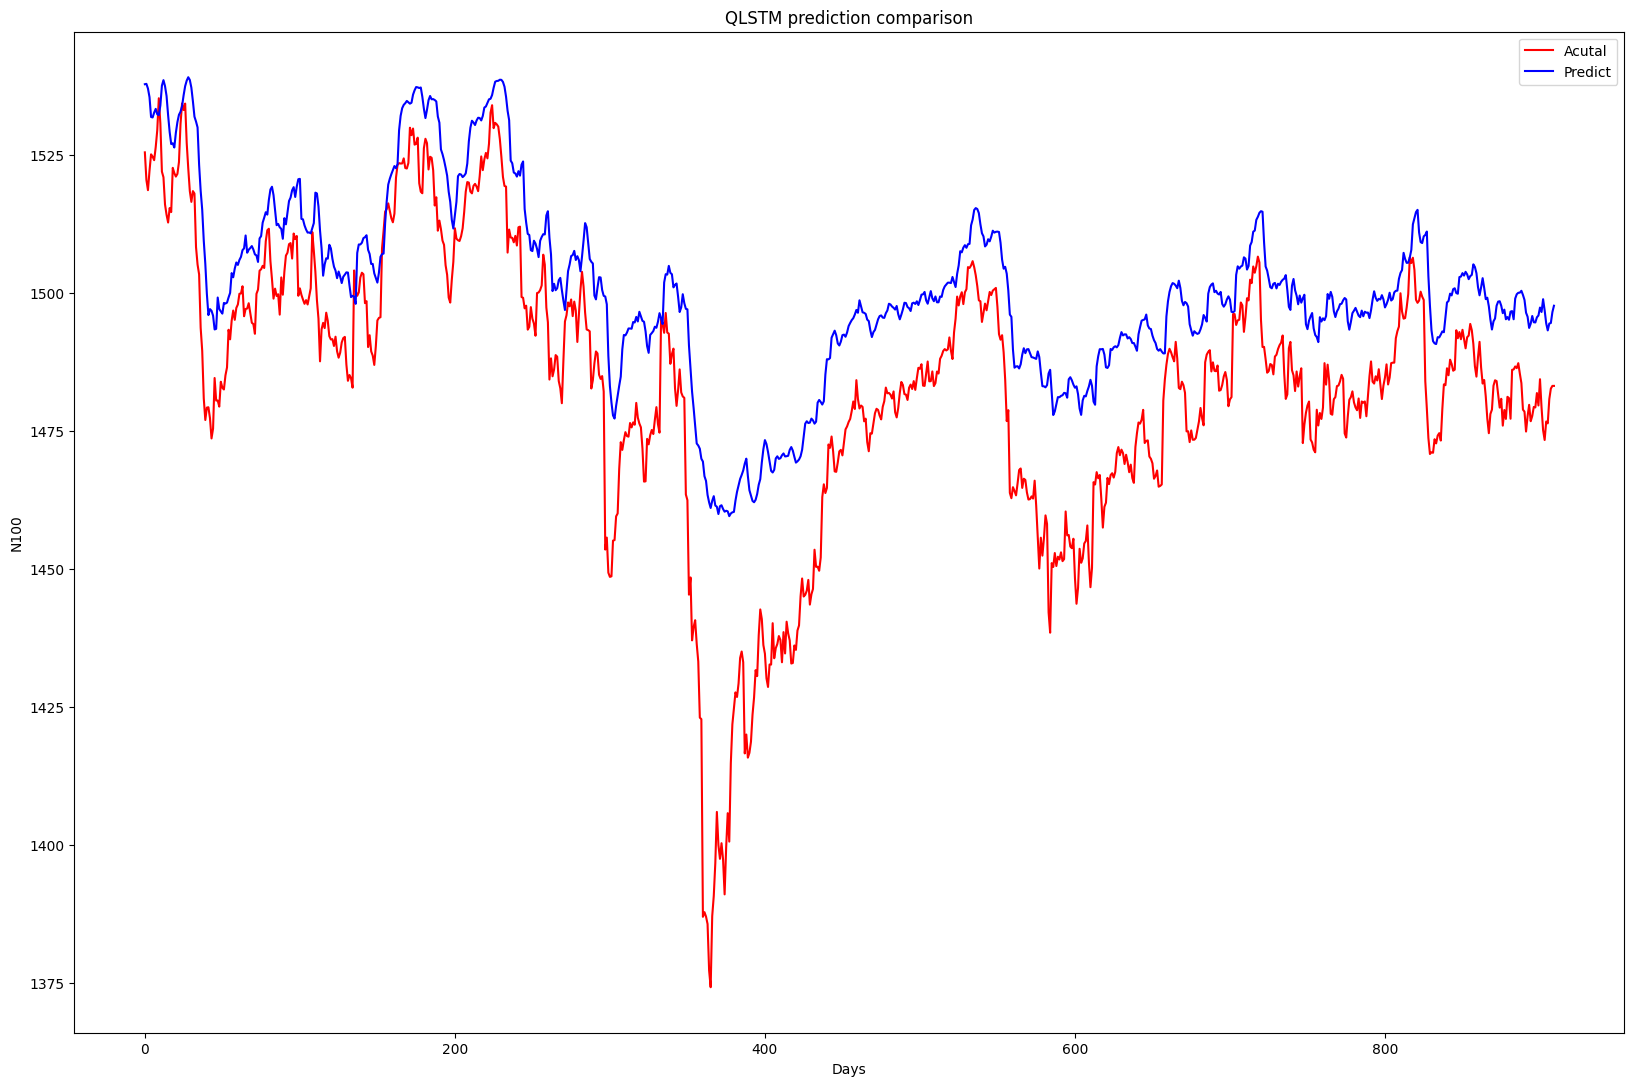

In [30]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('N100')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [31]:
torch.save(modelQ.state_dict(),'./SavedModels/Stock/N100/model/stacked_QLSTM_sd')